Probabilistic Inverse Problem with Differentiable Simulations
=======================

This notebook will illustrate some of the concepts introduced in {doc}`probmodels-intro`, such as the training of score functions via log likelihoods, and what they look like in a clear and reduced problem. At the same time, the setup provides integration of a simple _differentiable simulator_ to illustrate the concept of physics-based diffusion modeling with the SMDP method from {doc}`probmodels-phys` [(full paper)](https://arxiv.org/abs/2301.10250). This approach combines physics and score matching along a merged time dimension to solve inverse problems. 
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/probmodels-sbisim.ipynb)

## Toy Problem setup

We'll consider a toy problem with quadratically decaying trajectories. The trajectories start at $1$ or $-1$ and approach $0$ as $t$ increases. 
The corresponding SDE is given by 

$$
\begin{align} 
    dx = - \left[ \lambda_1 \cdot \mathrm{sign}(x) x^2 \right] dt + \lambda_2 dw,
\end{align}
$$ (eq:app_sde_1d)

with $\lambda_1 = 7$ and $\lambda_2 = 0.03$. The corresponding reverse-time SDE is 

$$
\begin{align}
    dx = - \left[ \lambda_1 \cdot \mathrm{sign}(x) x^2 - \lambda_2^2 \cdot \nabla_x \log p_t(x) \right] dt + \lambda_2 dw.
\end{align} 
$$

Throughout the experiments, $p_0$ is a categorical distribution, where we draw either $1$ or $-1$ with the same probability. 



## Implementation Overview

The implementation below comprises the data generation, network definition, training using the sliding window method, 
visualization of the learned score and inference using the probability flow ODE and the reverse-time SDE. 
The core algorithm for training and inference can be modified easily for different variants that are discussed in the paper.


This implementation uses quite a few packages, which we'll import first. We'll make use of `JAX` with `haiku` and `optax` as neural network libraries. For data generation and inference, we use `diffrax`:

In [ ]:
try:
    import google.colab  # only to ensure that we are inside colab
    %pip install diffrax jax jaxlib scipy optax dm-haiku
except ImportError:
    print("This notebook is running locally, please make sure the packages above are installed")
    pass

In [4]:
import warnings
warnings.filterwarnings('ignore')

from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, WeaklyDiagonalControlTerm
import diffrax as dfx

import jax
import jax.random as jr
import jax.numpy as jnp
import optax
import haiku as hk

In addition to several widely used numpy and matplotlib libraries:

In [5]:
import math
import numpy as np
from tqdm import tqdm
from scipy.interpolate import griddata
from typing import Any, Callable, Iterable, List, Optional, Tuple, Union

from matplotlib import pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

## Physical System SDE

Next we set up a lambda function for the SDE above with constants $\lambda = 7$ and $g = 0.03$. 

In [7]:
g = 0.03
lambda_ = 7
physics_operator = lambda x: - jnp.sign(x) * x * x * lambda_

We use diffrax to solve the SDE with Euler steps

In [8]:
def r_process(initial_value, noise_scaling, seed):

    initial_shape = (1,)
    y0 = jnp.ones(shape=initial_shape) * initial_value

    t0, t1 = 0.0, 10.0
    drift = lambda t, y, args: physics_operator(y)

    diffusion = lambda t, y, args: noise_scaling * jnp.ones(initial_shape)

    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=initial_shape, key=jr.PRNGKey(seed))
    terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))
    solver = Euler()
    saveat = SaveAt(dense=True)

    sol = diffeqsolve(terms, solver, t0, t1, dt0=0.01, y0=y0, saveat=saveat)

    return sol

## Visualization of SDE paths
We first set a *seed* for the SDE paths, and plot some example paths from the SDE.

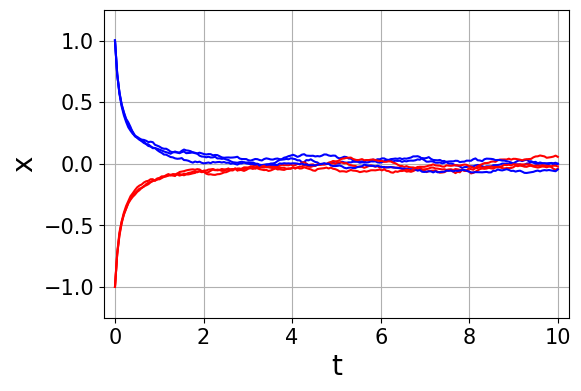

In [12]:
seed = 2022

if 1:
    # paths starting in 1.0
    value_one = [r_process(1.0, g, seed+n) for n in range(0, 3)]

    # paths starting in -1.0
    value_minus_one = [r_process(-1.0, g, seed+n) for n in range(3, 6)]

    fig, ax = plt.subplots(figsize=(6,4))

    x = jnp.linspace(0,10,200)

    for i in range(3):

        sol = value_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='blue')

        sol = value_minus_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='red')

    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_xlabel('t', size = 20)
    ax.set_ylabel('x', size = 20)
    ax.grid(True)
    ax.tick_params(labelsize=15)

    plt.xlim([-0.25, 10.25])
    plt.ylim([-1.25,1.25])

    plt.show()

As promised, the trajectories start on either side (blue and red), and approach the zero line in a stochastic fashion.

## Generate Training Data

We generate a data set of 250 paths from $t=0$ until $t=10$ with $\Delta t = 0.02$

In [13]:
import os.path
import pickle

if os.path.isfile('toy_example_data.p'):

    with open('toy_example_data.p', 'rb') as file:

        dataset = pickle.load(file)

else:

    dataset = []
    x = jnp.linspace(0,10,500)

    for n in tqdm(range(250)):
        sol = r_process((-1) ** n, g, seed+n)
        dataset.append(jnp.diag(sol.evaluate(x)))

data = jnp.array(dataset)


100%|██████████| 250/250 [04:39<00:00,  1.12s/it]


In [14]:
import pickle
with open('toy_example_data.p', 'wb') as file:
    pickle.dump(dataset, file)

Next, we implement iterator functions for the dataset

In [15]:
def _prepare_batch(batch):

    batch_x = batch[:,::-1]
    batch_t = jnp.linspace(0,10, batch_x.shape[1])[::-1]

    return (batch_x, batch_t)

def iterbatches(X, batch_size, shuffle=False):


    def iterate(X, batch_size, shuffle=False):
        n_samples = X.shape[0]

        ids = np.arange(n_samples)
        sample_perm = np.arange(n_samples)
        if batch_size is None:
            batch_size = n_samples
        if shuffle:
            sample_perm = np.random.permutation(n_samples)
        batch_idx = 0
        num_batches = math.ceil(n_samples / batch_size)
        while batch_idx < num_batches:
            start = batch_idx * batch_size
            end = min(n_samples, (batch_idx + 1) * batch_size)
            indices = range(start, end)

            perm_indices = sample_perm[indices]
            X_batch = X[perm_indices]
            ids_batch = ids[perm_indices]

            batch_idx += 1
            yield X_batch

    return iterate(X, batch_size, shuffle)

Additionally, we implement iterator functions required for the score field visualization

In [16]:
def _prepare_batch_grid(batch):

    inputs = [np.split(x, x.shape[1], 1) for x in batch]

    return inputs

def iterbatches_grid(X, batch_size, shuffle=False):

    def iterate(X, batch_size, shuffle=False):
        n_samples = X.shape[0]

        sample_perm = np.arange(n_samples)
        if batch_size is None:
            batch_size = n_samples
        if shuffle:
            sample_perm = np.random.permutation(n_samples)
        batch_idx = 0
        num_batches = math.ceil(n_samples / batch_size)
        while batch_idx < num_batches:
            start = batch_idx * batch_size
            end = min(n_samples, (batch_idx + 1) * batch_size)
            indices = range(start, end)

            perm_indices = sample_perm[indices]
            X_batch = X[perm_indices]

            batch_idx += 1
            yield ([X_batch])

    return iterate(X, batch_size, shuffle)

### Neural Network Setup

This example employs a neural network $s_\theta(x,t)$ parameterized by $\theta$ to approximate the score. It's a simple multilayer perceptron with elu activations and five hidden layers with $30$, $30$, $25$, $20$, and then $10$ neurons for the last hidden layer.

The neural network architecture is realized with `haiku`, using a stack of MLPs:

In [17]:
EPSILON = 1e-5

def f(x, t):
    t = jnp.log(t + EPSILON)
    x = jnp.hstack([x, t])
    net = hk.nets.MLP(output_sizes = [30, 30, 25, 20, 10, 1],
                    activation = jax.nn.elu)
    return net(x)

The next cell initializes the parameters. The `forward_fn` will be our main handle to evaluate the network `f` later on.

In [18]:
init_params, forward_fn = hk.transform(f)
rng = jax.random.PRNGKey(0)

x_init = jnp.ones((10,1))
t_init = x_init
params = init_params(rng, x_init, t_init)

We also define a function to evaluate the model and a function that implements the backpropagation and updating of parameters given the optimizer and model loss.

In [19]:
def create_eval_fn(forward_fn, params):
    @jax.jit
    def eval_model(t, x, rng=None):

        res = forward_fn(params, rng, x, t)
        return res
    return eval_model

def create_default_update_fn(optimizer: optax.GradientTransformation,
                             model_loss: Callable):

    @jax.jit
    def update(params, opt_state, batch, rng) -> Tuple[hk.Params, optax.OptState, jnp.ndarray]:

        batch_loss, grads = jax.value_and_grad(model_loss)(params, rng, *batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, batch_loss
    return update

Finally, we implement the ODE solver for the probability flow ODE using Euler steps. 
Given an initial state and ground truth (**x_train**) as well as time discretization (**t_train**), it computes the L2 loss:

In [20]:
def gradient_fn(forward_fn, physics_operator, g):

    @jax.jit
    def model_loss(model_weights, rng, x_train, t_train):
        x = x_train[:,0]
        i = 1
        loss = 0.0

        for t1, t0 in zip(t_train, t_train[1:]):
            delta_t = t1-t0
            physics_update = physics_operator(x)

            # note that we absorb g**2 (constant) in the definition of forward_fn here
            score_update = - 0.5 * forward_fn(model_weights, rng, jnp.expand_dims(x, axis=1),
                                              jnp.repeat(jnp.tile(t1, 1)[None], x.shape[0], axis=0))[:,0]

            x = x - delta_t * (physics_update + score_update)
            x_true = x_train[:,i]
            loss += jnp.mean(jnp.square(x - x_true))
            i += 1

        return loss
    return model_loss

### Visualizing the Score Field

While the problem itself is very clear, it's actually much less obvious what the score function underneath should look like. Hence, we'll show different version of score functions below, and the next cell implements a helper function that takes care of the visualization of the score field. 
We'll sample the score function on a regular grid to show it as an image, and hence first set up the corresponding grids.

In [21]:
x_ = np.linspace(0., 10., 400)
y_ = np.linspace(-1.25, 1.25, 200)

X, Y = np.meshgrid(x_,y_)
full_domain = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
meshgrid = (X,Y)

The following function `save_snapshot_score` plots a score function as an image.

In [22]:
dpi = 200
height = 6
width = 4
scaling_factor = 1.

def save_snapshot_score(params, forward_fn, meshgrid, step=None, savename=None):
    eval_fn = create_eval_fn(forward_fn, params)
    results = None
    X, Y = meshgrid
    full_domain = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
    full_domain_scaled = full_domain * scaling_factor

    generator = iterbatches_grid(full_domain_scaled, 1000, shuffle=False)
    for batch in generator:
        inputs = _prepare_batch_grid(batch)

        output_values = eval_fn(*inputs[0], rng)
        if isinstance(output_values, jnp.ndarray):
            output_values = [output_values]
        output_values = [jax.device_get(t) for t in output_values]

        if results is None:
            results = [[] for i in range(len(output_values))]
        for i, t in enumerate(output_values):
            results[i].append(t)

    final_results = []
    if results is not None:
        for r in results:
            final_results.append(np.concatenate(r, axis=0))

    x_scaled = x_ * scaling_factor
    y_scaled = y_ * scaling_factor
    meshgrid_scaled = (meshgrid[0] * scaling_factor, meshgrid[1] * scaling_factor)

    fig, axes = plt.subplots(nrows = 1, ncols=1, figsize=(height,width))
    fig.set_dpi(dpi)

    ax = axes
    u_pred = final_results[0][:].flatten()
    U_pred = griddata(full_domain_scaled, u_pred.flatten(), meshgrid_scaled, method='cubic')

    vmax = 75
    h = ax.imshow(jnp.flip(U_pred / (g**2), axis=0), cmap='jet',
                  extent=[ x_scaled.min(), x_scaled.max(), y_scaled.min(), y_scaled.max()],
                  aspect='auto', vmin = -vmax, vmax = vmax)
    cbar = fig.colorbar(h)
    ax.set_xlabel("t")
    ax.set_ylabel("x")

    plt.figure(figsize=(10, 6)) # NT_DEBUG , test
    if savename:
        plt.savefig(f'{savename}.svg', transparent=True)
    plt.show()

Let's take a loot at the untrained score function `forward_fn`:

In [ ]:
save_snapshot_score(params, forward_fn, meshgrid)

Not too surprisingly, it contains random but smooth transitions. Let's revisit it after a first training run.

## Training and Sliding Window Method

Next we implement functions for network training. We implement the _sliding window_ method and corresponding training algorithm below. 

The sliding window method starts with window size **ROLLOUT_start**, which is increased by **ROLLOUT_add** every **steps** epochs for **ROLLOUT_increases** times. 
To reduce the number of points on a trajectory, we use subsampling (defined by **subsample**)

In [23]:
def update_network(params_, forward_fn, dataset, rng, steps = 20, ROLLOUT_increases = 18, max_training_time=None,
                   ROLLOUT_start = 4, ROLLOUT_add = 2, lr=5e-4, bidirectional=False, subsample=5):

    scheduler = optax.piecewise_constant_schedule( init_value=lr)

    # Optax otimizer using Adam
    opt = optax.chain(
        optax.scale_by_adam(b1=0.9, b2=0.99),
        optax.scale_by_schedule(scheduler),
        optax.scale(-1.0))
    opt_state = opt.init(params_)

    # Define model loss and update for network parameters
    model_loss_fn = gradient_fn(forward_fn, physics_operator, g)
    grad_update = create_default_update_fn(opt, model_loss_fn)

    avg_loss = 0
    grad_updates = 0
    ROLLOUT = ROLLOUT_start
    history = []

    # Iterate through all sliding window sizes
    for _ in range(ROLLOUT_increases+1):
        print('Window size: ', ROLLOUT)
        pbar = tqdm(range(steps))

        # Iterate through all epochs
        for n in pbar:

            # Iterate through data set
            generator = iterbatches(dataset, 256, shuffle=False)
            for batch in generator:
                x_train, t_train = _prepare_batch(batch)


                # Concentrate on specific parts of trajectory
                if max_training_time is not None:

                    x_train = x_train[:, -max_training_time:]
                    t_train = t_train[-max_training_time:]

                # Use subsampling to reduce number of points on trajectory
                x_train = x_train[:, ::subsample]
                t_train = t_train[::subsample]

                # Iterate through trajectory
                for t in range(x_train.shape[1]):

                    # Select values based on position and window size
                    x_train_sub = x_train[:, t:t+ROLLOUT]
                    t_train_sub = t_train[t:t+ROLLOUT]

                    # Compute loss for current part of trajectory
                    params_, opt_state, batch_loss_backward = grad_update(params_, opt_state, [x_train_sub, t_train_sub], rng=rng)

                    # Reverse values and time discretization for the forward time direction
                    if bidirectional:
                        params_, opt_state, batch_loss_forward = grad_update(params_, opt_state,
                                                                             [x_train_sub[:,::-1], t_train_sub[::-1]], rng=rng)

                    grad_updates += 1

                    rng, _ = jax.random.split(rng)
                    avg_loss += jax.device_get(batch_loss_backward)
                    if bidirectional:
                        avg_loss += jax.device_get(batch_loss_forward)

                    history.append(batch_loss_backward+batch_loss_forward)

            pbar.set_description(f'loss: {avg_loss/(n+1):.5f} grad updates: {grad_updates}')

        ROLLOUT += ROLLOUT_add

    return params_, history

### Single step loss 
We train the score network with the single step loss for 2500 epochs using the probability flow ODE (see Single steps, Section 3).
Single step is realized here with a _sliding window_ of size 2, i.e. going one step forward in time for each sample. Increases of the unrolling are disabled via `ROLLOUT_increases=0` by default below. This speeds up training for default runs, but feel free to enable the increases in subsequent tests.
We also use subsampling with factor 5 to reduce the number of points on the trajectory. After training, the resulting score function is visualized again.

Window size:  2


loss: 0.02322 grad updates: 250000: 100%|██████████| 2500/2500 [10:23<00:00,  4.01it/s]


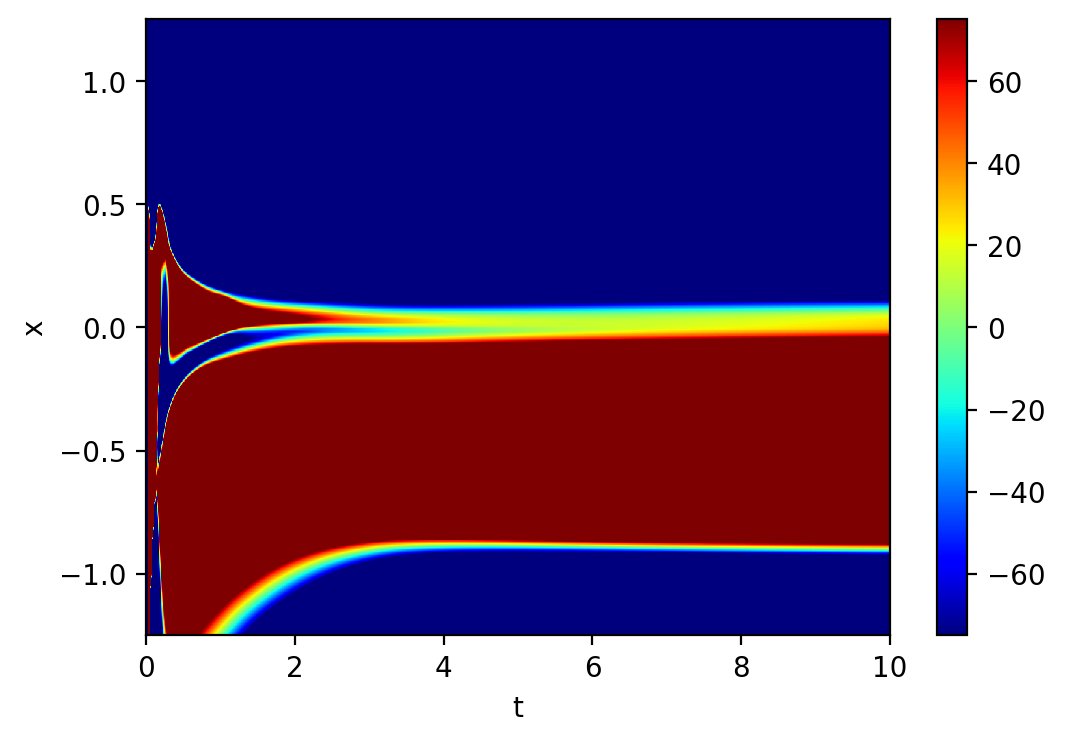

In [25]:
ROLLOUT_increases=0

key = jax.random.PRNGKey(seed)
params_single_step, history = update_network(params, forward_fn, data, key, steps = 2500,
                                             ROLLOUT_start=2, ROLLOUT_increases=ROLLOUT_increases, bidirectional=True, lr=1e-3,
                                             subsample=5)


save_snapshot_score(params_single_step, forward_fn, meshgrid)

This should look more meaningful than the initial random state! The two bands of trajectories from -1 and 1 should be visible. E.g., the blue region at the top indicates a large negative gradient, driving samples ending up in this  region down by a large distance, towards the correct trajectory in the positive region (as shown further above). Note that some parts, typically closer to the end time ($t=10$ on the right), can show sign changes and mostly random content again. This is caused by the network primarily being trained in the vicinity of samples it has seen in the training data. Far away from it, it has "not learned" how to properly transform samples into admissible ones.

We also plot the training loss below, to show the training progressing for this first training step.

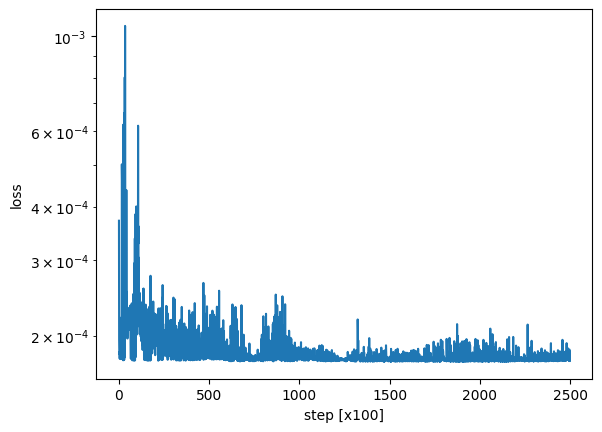

In [26]:
plt.plot(np.array(history[::100]))
plt.yscale('log')
plt.xlabel('step [x100]')
plt.ylabel('loss')
plt.show()

For the next training step, the goal is to improve the quality of the learned score:
We decrease the learning rate and train without reducing the trajectories via "subsampling", meaning all samples in the training data are provided to the network.

Window size:  2


loss: 0.01599 grad updates: 500000: 100%|██████████| 1000/1000 [20:41<00:00,  1.24s/it]


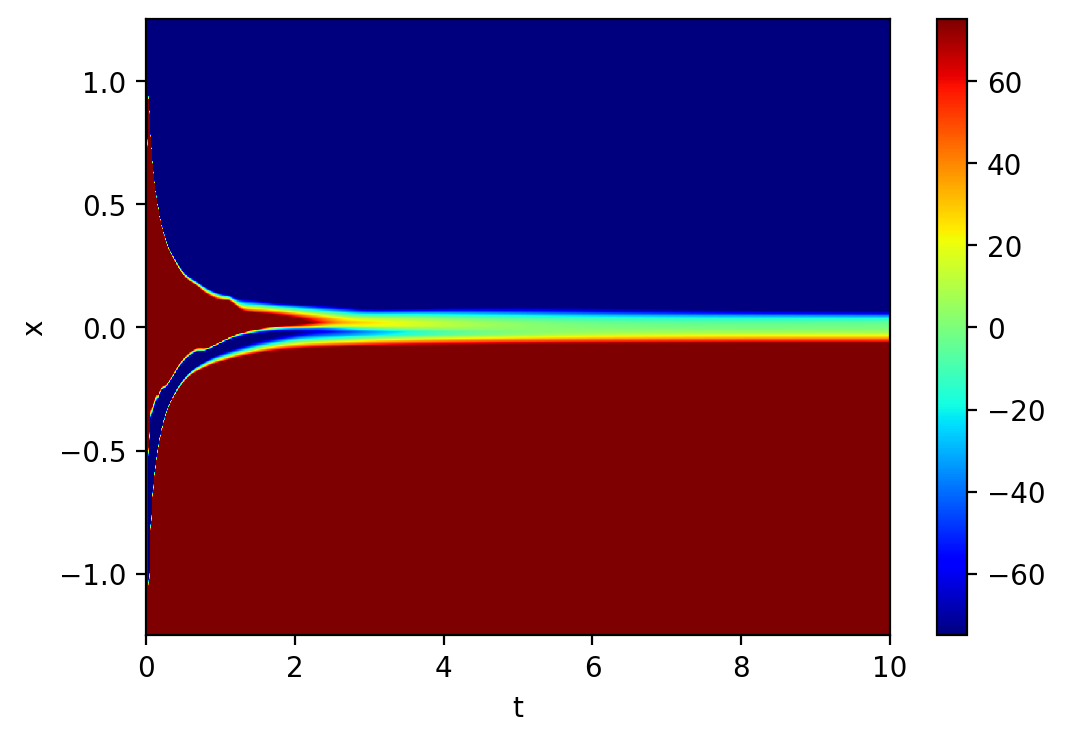

In [27]:
params_single_step, history = update_network(params_single_step, forward_fn, data, key, steps = 1000,
                                             ROLLOUT_start=2, ROLLOUT_increases=ROLLOUT_increases, bidirectional=True, lr=1e-4,
                                             subsample=1)

save_snapshot_score(params_single_step, forward_fn, meshgrid)

This typically results in an even _cleaner_ score function, containing fewer sign changes outside the two bands of the ground truth trajectories. The runtime above was reduced via the `ROLLOUT_increases=0` setting. Once you enable it, e.g., with `ROLLOUT_increases=10` potentially with an increased number of iterations, you should see further improvements of the score field in the visualization.

The training in this stage is also more stable, as shown in the corresponding plot below.

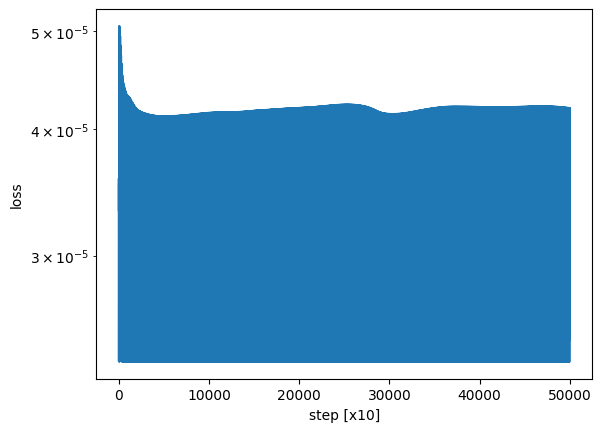

In [28]:
plt.plot(np.array(history[::10]))
plt.yscale('log')
plt.xlabel('step [x10]')
plt.ylabel('loss')
plt.show()

## Sampling SDE and ODE trajectories

Above we've only looked at the learned score function, and thus we'll evaluate the trajectories produces by integrating the two DE variants.
We use the trained score with `diffrax` to solve the probability flow ODE and simulate paths from the reverse-time SDE. 

### Reverse-time SDE
We define a function to simulate paths from the reverse-time SDE with `diffrax`, where `WeaklyDiagonalControlTerm(diffusion, brownian_motion)` takes care of the noise:

In [29]:
def r_process_reverse(initial_value, params, noise_scaling, seed):
    key = jr.PRNGKey(seed)
    initial_shape = (1,)
    y1 = jnp.ones(shape=initial_shape) * initial_value
    t0, t1 = 0.0, 10.0
    dt0 = 0.01

    def drift(t, y, args):
        return physics_operator(y) - forward_fn(params, key, y, t)

    diffusion = lambda t, y, args: noise_scaling * jnp.ones(initial_shape)

    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=initial_shape, key=key)
    terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))

    solver = dfx.Euler()
    t0 = jnp.array(0.0)
    args = None
    tprev = jnp.array(t1)
    tnext = jnp.array(t1 - dt0)
    y = y1

    state = solver.init(terms, tprev, tnext, y1, args)
    y_list = []
    for i in range(((t1-t0) / dt0).astype(int)):
        y, _, _, state, _ = solver.step(terms, tprev, tnext, y, args, state, made_jump=False)
        tprev = tnext
        tnext = jnp.array(jnp.maximum(tprev - dt0, t0))
        y_list.append(y)

    return y_list

and plot ten different paths sampled from the reverse-time SDE:

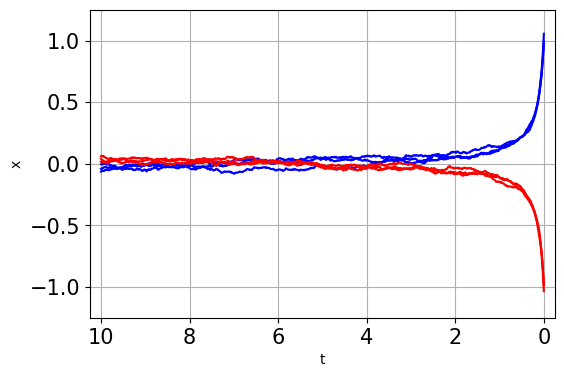

In [30]:
if 1:
    combinations = zip(np.linspace(-0.065,0.065, 6), range(6))
    fig, ax = plt.subplots(figsize=(6,4))

    for init, seed_ in combinations:
        sol = r_process_reverse(init, params_single_step, g, seed_)
        if sol[-1] > 0:
            col = 'blue'
        else:
            col = 'red'
        ax.plot(np.linspace(10.0, 0.0, 1000), sol, color=col)

    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.grid(True)
    ax.tick_params(labelsize=15)

    plt.xlim([10.25, -0.25])
    plt.ylim([-1.25,1.25])
    plt.show()

Note that the trajectories are shown along integration of the reverse-time SDE, and thus they appear mirrored along y in comparison to the ground truth ones above. With default settings, these trajectories should look quite good: exhibiting noisy motions during the initial phase, and reliably converging to $1$ and $-1$.

If you reduce accuracy or training duration, you'll see that the score will contain erroneous regions, giving particles that shoot off before reaching $t=0$.

### Probability flow ODE

The probability flow ODE, as deterministic counterpart of the SDE, is an interesting variant that is obtained by removing the `brownian_motion` diffusion term.
Analogously, we define a function to solve the probability flow ODE using only the drift term:

In [31]:
def r_process_reverse_ode(initial_value, params, noise_scaling, seed):
    key = jr.PRNGKey(seed)
    initial_shape = (1,)
    y1 = jnp.ones(shape=initial_shape) * initial_value
    t0, t1 = 0.0, 10.0
    dt0 = 0.01

    def drift(t, y, args):
        return physics_operator(y) - 0.5 * forward_fn(params, key, y, t)

    terms = ODETerm(drift)
    solver = dfx.Euler()
    t0 = jnp.array(0.0)

    args = None
    tprev = jnp.array(t1)
    tnext = jnp.array(t1 - dt0)
    y = y1
    state = solver.init(terms, tprev, tnext, y1, args)
    y_list = []

    for i in range(((t1-t0) / dt0).astype(int)):
        y, _, _, state, _ = solver.step(terms, tprev, tnext, y, args, state, made_jump=False)
        tprev = tnext
        tnext = jnp.array(jnp.maximum(tprev - dt0, t0))
        y_list.append(y)

    return y_list

Finally, we can plot the solutions to the probability flow ODE

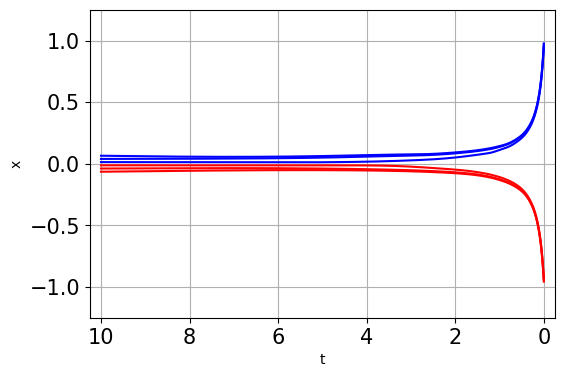

In [32]:
#with plt.style.context("seaborn-white"):
if 1:
    combinations = zip(np.linspace(-0.065,0.065, 6), range(6))

    fig, ax = plt.subplots(figsize=(6,4))

    for init, seed_ in combinations:
        sol = r_process_reverse_ode(init, params_single_step, g, seed_)
        if sol[-1] > 0:
            col = 'blue'
        else:
            col = 'red'
        ax.plot(np.linspace(10.0, 0.0, 1000), sol, color=col)

    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.grid(True)
    ax.tick_params(labelsize=15)

    plt.xlim([10.25, -0.25])
    plt.ylim([-1.25,1.25])
    plt.show()

They show the influence of the score without random perturbations, and in this case provide mostly horizontal motions with a bifurcation towards the two end points.

## Next steps

* In this notebook it's worth experimenting with the unrolling steps (cf. `ROLLOUT_increases` above), to evaluate their effect on learning the score.
* In addition, it's interesting to intentionally deteriorate the quality of the score with short training runs. This should results in chaotic and erroneous trajectories.